In [1]:
#importing neccessary packages...

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [2]:
#creating conectionwith the sqlite file
con = sqlite3.connect('final.sqlite') 

#Reading the entire data from the file and storing it into a dataframe...
data = pd.read_sql_query("select * from Reviews", con)
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [3]:
# sampling 5k positive review points..
data1=data[data.Score=='positive'].sample(n=5000)

In [4]:
# sampling 5k negative review points..
data2=data[data.Score=='negative'].sample(n=5000)

In [5]:
# merging both positive and negative points into a single dataframe...
frames=[data1,data2]
final_data=pd.concat(frames)

In [7]:
# storing the "Score" feature into a separate variable...
label=final_data["Score"]


In [8]:
# Text to vector conversion..
# Creating bag of words on the cleaned Text...
#BoW
count_vect = CountVectorizer() #in scikit-learn
bow = count_vect.fit_transform(final_data['CleanedText'].values)

In [9]:
bow.shape

(10000, 13160)

In [10]:
type(bow)

scipy.sparse.csr.csr_matrix

### NOTE
Clearly its a sparse matrix..for which TSVD will be very useful.

In [10]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(bow)
print(standardized_data.shape)


(10000, 13648)


C:\Users\vishu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [11]:
#importing TruncatedSvd...
from sklearn.decomposition import TruncatedSVD


In [12]:
# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=standardized_data.shape[1]-1)
X_tsvd = tsvd.fit(standardized_data)


In [13]:
# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_

In [14]:
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [15]:
# Run function with 95% of the variance..
select_n_components(tsvd_var_ratios, 0.95)

4856

## Conclusion
clearly its visible that only "4856" components have the variance of 95%...

In [16]:
# running Tsvd only on 4856 components...
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=4845, random_state=42)
tsvd_data=svd.fit_transform(standardized_data)

In [17]:
type(tsvd_data)

numpy.ndarray

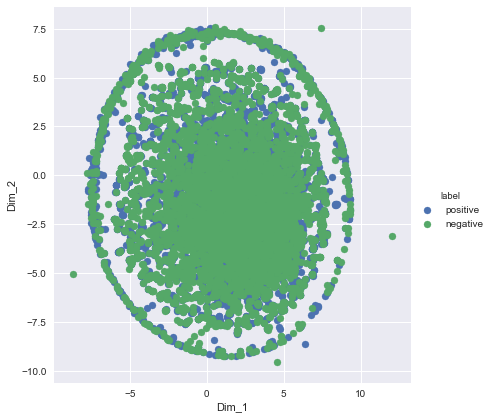

In [18]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
#data_1000 = standardized_data[0:1000,:]
#labels_1000 = labels[0:1000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(tsvd_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

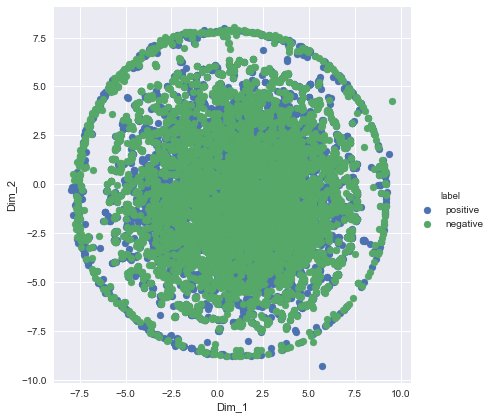

In [19]:
from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
#data_1000 = standardized_data[0:1000,:]
#labels_1000 = labels[0:1000]

model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(tsvd_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Conclusion
The positive and negative points are completely overlapping each other so they are not separable at all...